In [18]:
import botree
import pendulum
from pathlib import Path
import xarray as xr
import pandas as pd
import numpy as np
import concurrent.futures

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl

from utils import padronizar_longitude
from utils import delimitar_regiao
from utils import converter_para_celsius

from regioes_indices import regioes2

In [19]:
#clima_oiv2 = pd.read_csv('oiv2_clima_1991-2020.csv', sep=';', index_col='mes')
#historico_oiv2 = pd.read_csv('oiv2_historico_1981-2022.csv', sep=';', index_col='data')

clima_oiv2 = pd.read_csv('oisstv2_clima_1991-2020.csv', sep=';', index_col='mes')
historico_oiv2 = pd.read_csv('oiv2_HistoricoNovo_2020-2022.csv', sep=';', index_col='data')
clima_texto = "1991-2020 OIv2.1"

In [20]:
#session = botree.session("us-east-1")
bucket = 'noaa-cfs-pds'

In [21]:
ciclo_base = '00'
resolucao_temporal = 'monthly_grib'
ciclos = ['00', '06', '12', '18']

In [6]:
data_requerida = '19-09-2022'

In [22]:
inicio = pendulum.from_format(data_requerida, 'DD-MM-YYYY')
final = inicio.subtract(days=9)
periodo = pendulum.period(inicio, final)

In [23]:
def leitura_arquivos_cfs(arquivos_locais, data, ciclo):
    
    membro = '1'
    dicionario = {}
    for indice in regioes2:
        dicionario[indice.nome] = 0
    
    ds = xr.open_mfdataset(
        arquivos_locais[:],
        engine='cfgrib',
        combine='nested',
        concat_dim='valid_time',
        backend_kwargs=dict(
            filter_by_keys=dict(
                typeOfLevel='surface', shortName='t'
            )
        )
    )
    
    for indice in regioes2:
        
        if indice.longitude_padronizada:
            ds_padronizado = padronizar_longitude(ds, xdim='longitude')
            nino = delimitar_regiao(obj=ds_padronizado, indice=indice)
        else:
            ds_padronizado = ds
            nino = delimitar_regiao(obj=ds_padronizado, indice=indice)
        
        nino_celsius = converter_para_celsius(nino)
        nino_df = nino_celsius.to_dataframe()

        nino_df.drop(columns=['time', 'step', 'surface'], inplace=True)
        nino_df.rename(columns={'t': f"{data.format('YYYYMMDD')}_{membro}_{ciclo}"}, inplace=True)

        n_passos = len(nino_df.index)
        passos = range(0, n_passos, 1)
        meses_previstos = [data.add(months=passo).replace(day=1) for passo in passos]
        nino_df = nino_df.assign(data=meses_previstos)
        nino_df.set_index('data', inplace=True)
        
        dicionario[indice.nome] = nino_df
    
    return dicionario

In [24]:
def baixa_async(data, ciclo):
    
    session = botree.session("us-east-1")
    
    membro = '1'
    data_fmt = data.format('YYYYMMDD')
    prefixo = f"cfs.{data_fmt}/{ciclo}/{resolucao_temporal}_{membro.zfill(2)}/ocnf.{membro.zfill(2)}"

    dir_membro = Path(data_fmt, membro)
    dir_membro.mkdir(exist_ok=True, parents=True)

    arquivos_ocn = session.s3.bucket(bucket).list_objects(prefixo)


    diretorio_ciclo = dir_membro.joinpath(ciclo)
    diretorio_ciclo.mkdir(exist_ok=True, parents=True)
    arquivos_ja_baixados = list(diretorio_ciclo.glob("*grb2"))

    arquivos_da_rodada = list()
    for arquivo in arquivos_ocn:
        if arquivo.endswith(f'avrg.grib.grb2'):            #(f'{ciclo}Z.grb2'):
            arquivo_path = Path(arquivo)
            arquivo_local = diretorio_ciclo.joinpath(arquivo_path.name)
            if arquivo_local in arquivos_ja_baixados:
                pass
            else:
                session.s3.bucket(bucket).download(arquivo, arquivo_local)
            arquivos_da_rodada.append(arquivo_local)

    arquivos_locais = [diretorio_ciclo.joinpath(Path(arquivo).name) for arquivo in arquivos_da_rodada]
    
    return arquivos_locais

In [25]:
def processa_cfs_async(data, ciclo):
    
    arquivos_locais = baixa_async(data, ciclo)
    
    nino_df = leitura_arquivos_cfs(arquivos_locais, data, ciclo)
    
    return nino_df

In [26]:
def calcula_anomalia(indice, df: pd.DataFrame, clima_oiv2: pd.DataFrame=clima_oiv2):
    
    for coluna in df.columns:
        if not coluna == 'mes':
            for index in df.index:
                df.loc[index, coluna] = df[coluna][index] - clima_oiv2[indice.nome][index.month]
        else: 
            pass
        
    return df

In [27]:
def processo_plot(dados, indice):
    
    lista_qualquer = list()
    for dado in dados:
        lista_qualquer.append(dado[indice.nome])

    df_mensal = pd.concat(lista_qualquer, axis=1)
    datas_e_ciclos = df_mensal.columns
    df_mensal = df_mensal.assign(mes=df_mensal.index.month)
    
    df_final = calcula_anomalia(indice=indice, df=df_mensal)

    df_sem_mes_int = df_final.loc[:, df_final.columns != 'mes']
    ensemble = df_sem_mes_int.mean(axis='columns')
    
    fig = plot_indice(indice, df_sem_mes_int, ensemble)
    
    return fig

In [28]:
def seleciona_historico(nome_indice, df_historico=historico_oiv2, qtd_meses=12, add_mes_corrente:bool=False, ensemble=None):
    
    df_historico.index = pd.to_datetime(df_historico.index)
    historico_para_plot = df_historico.tail(qtd_meses)
    dados = {'time': historico_para_plot.index, 'anom': historico_para_plot[f'{nome_indice} anom']}
    historico = pd.DataFrame(data=dados)
    historico = historico.reset_index(drop=True)
    
    if add_mes_corrente:
        dados_ensemble = {'time': ensemble.index[0], 'anom': ensemble.values[0]}
        df_ensemble = pd.DataFrame(data=dados_ensemble, index=[0])
        
        historico = pd.concat([historico.set_index('time'), df_ensemble.set_index('time')])
        historico.index = pd.to_datetime(historico.index, utc=True)
        
    else: 
        historico = historico.set_index('time')
    
    return historico


def gera_indice_de_datas(historico, ensemble):
    
    serie_datas = pd.concat([historico, ensemble])
    indice_data = pd.to_datetime(serie_datas.index, utc=True)
    return indice_data

In [29]:
def plot_indice(indice, df_sem_mes_int, ensemble):
    
    print(f"inicio: {pendulum.now().format('HH:mm:ss')}")

    plt.style.use('default')
    fonte_titulo = Path('fonts', "Exo2-VariableFont_wght.ttf")
    fonte_outros = Path('fonts', "SourceSansPro-Light.ttf")
    myfont1 = mpl.font_manager.FontProperties(fname=fonte_outros, size=24)

    fig, ax = plt.subplots(figsize=(16,8))

    locator = mdates.AutoDateLocator()
    formatter = mdates.ConciseDateFormatter(locator)
    formatter.zero_formats = ['', '%b\n%Y', '%b', '%b-%d', '%H:%M', '%H:%M']
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

    plt.suptitle(f'CFSv2 - Previsão de anomalia de {indice.nome}', font=fonte_titulo, fontsize=30, y=1.05)
    plt.title(f'19/09/2022', loc='left', font=fonte_outros, fontsize=28, pad=20)
    plt.title(f'Climatologia: {clima_texto}', loc='right', font=fonte_outros, fontsize=28, pad=20)
    plt.xticks(font=fonte_outros, fontsize=24)
    plt.yticks(font=fonte_outros, fontsize=18)
    plt.axhline(y=0, color='#000000', linestyle='--')
    ax.set_ylabel('Anomalia de temperatura (°C)', fontsize=20, font=fonte_outros)

    contador = 0
    for membro in df_sem_mes_int.columns: # iterador era "i"

        if contador in range(0,7):
            cor = "#182630" #'b'
            label = 'Últimos 8 membros de previsão'
        elif contador in range(32,40):
            cor= "#F51347" #'r'
            label = 'Primeiros 8 membros de previsão'
        else:
            cor='#AFBEBE'
            label = 'Outros membros de previsão'

        indice_data = df_sem_mes_int.index
        ax.plot(indice_data, df_sem_mes_int[membro], cor, label=label, linewidth=1)
        contador = contador + 1

    ax.plot(indice_data, ensemble, "#000000", linewidth=2, linestyle=(5, (10, 3)), label='NCEI OIv2.1 daily analisys + Ensemble')

    historico = seleciona_historico(indice.nome)
    ax.plot(historico.index, historico.anom,"#000000", linewidth=2, linestyle='-', label='NCEI OIv2.1 daily analisys + Ensemble')

    # Major ticks every 20, minor ticks every 5
    major_ticks = np.arange(-10, 10, 0.5)
    ax.set_yticks(major_ticks)
    plt.grid(True)
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))

    limite_inferior = -3.1 if round(df_sem_mes_int.min().min()) > -3.1 else round(df_sem_mes_int.min().min() - 1)
    limite_superior = 3 if round(df_sem_mes_int.max().max()) < 3 else round(df_sem_mes_int.max().max() + 1)

    plt.ylim(limite_inferior, limite_superior)
    
    for key, spine in ax.spines.items():
        spine.set_visible(False)

    plt.legend(by_label.values(), by_label.keys(), prop=myfont1, loc='center', ncols=2, bbox_to_anchor=(0.5, -0.25), frameon=False)
    #fig.savefig(f'{indice.nome}.png', facecolor="white", bbox_inches="tight", dpi=300)

    print(f"fim: {pendulum.now().format('HH:mm:ss')}")
    
    return fig

In [30]:
def baixar_async(data, ciclo):
    
    session = botree.session("us-east-1")
    
    membro = '1'
    data_fmt = data.format('YYYYMMDD')
    prefixo = f"cfs.{data_fmt}/{ciclo}/{resolucao_temporal}_{membro.zfill(2)}/ocnf.{membro.zfill(2)}"

    dir_membro = Path(data_fmt, membro)
    dir_membro.mkdir(exist_ok=True, parents=True)

    arquivos_ocn = session.s3.bucket(bucket).list_objects(prefixo)


    diretorio_ciclo = dir_membro.joinpath(ciclo)
    diretorio_ciclo.mkdir(exist_ok=True, parents=True)
    arquivos_ja_baixados = list(diretorio_ciclo.glob("*grb2"))

    arquivos_da_rodada = list()
    for arquivo in arquivos_ocn:
        if arquivo.endswith(f'avrg.grib.grb2'):            #(f'{ciclo}Z.grb2'):
            arquivo_path = Path(arquivo)
            arquivo_local = diretorio_ciclo.joinpath(arquivo_path.name)
            if arquivo_local in arquivos_ja_baixados:
                pass
            else:
                session.s3.bucket(bucket).download(arquivo, arquivo_local)
            arquivos_da_rodada.append(arquivo_local)

    arquivos_locais = [diretorio_ciclo.joinpath(Path(arquivo).name) for arquivo in arquivos_da_rodada]
    ds = xr.open_mfdataset(
        arquivos_locais[:],
        engine='cfgrib',
        combine='nested',
        concat_dim='valid_time',
        backend_kwargs=dict(
            filter_by_keys=dict(
                typeOfLevel='surface', shortName='t'
            )
        )
    )

    ds_padronizado = padronizar_longitude(ds, xdim='longitude')
    nino = delimitar_regiao(obj=ds_padronizado, indice=indice)
    nino_celsius = converter_para_celsius(nino)
    nino_df = nino_celsius.to_dataframe()

    nino_df.drop(columns=['time', 'step', 'surface'], inplace=True)
    nino_df.rename(columns={'t': f"{data.format('YYYYMMDD')}_{membro}_{ciclo}"}, inplace=True)

    n_passos = len(nino_df.index)
    passos = range(0, n_passos, 1)
    meses_previstos = [data.add(months=passo).replace(day=1) for passo in passos]
    nino_df = nino_df.assign(data=meses_previstos)
    nino_df.set_index('data', inplace=True)
    
    return nino_df

In [31]:
arg1 = ()
arg2 = ()

for data in periodo.range('days'):
    for ciclo in ciclos:
        
        arg1 = arg1 + (data,)
        arg2 = arg2 + (ciclo,)

inicio: 21:49:23
inicio: 21:51:19
fim: 21:51:19
inicio: 21:51:19
fim: 21:51:20
inicio: 21:51:20
fim: 21:51:20
inicio: 21:51:20
fim: 21:51:20
inicio: 21:51:20
fim: 21:51:20
inicio: 21:51:20
fim: 21:51:20
inicio: 21:51:20
fim: 21:51:21
fim: 21:51:21


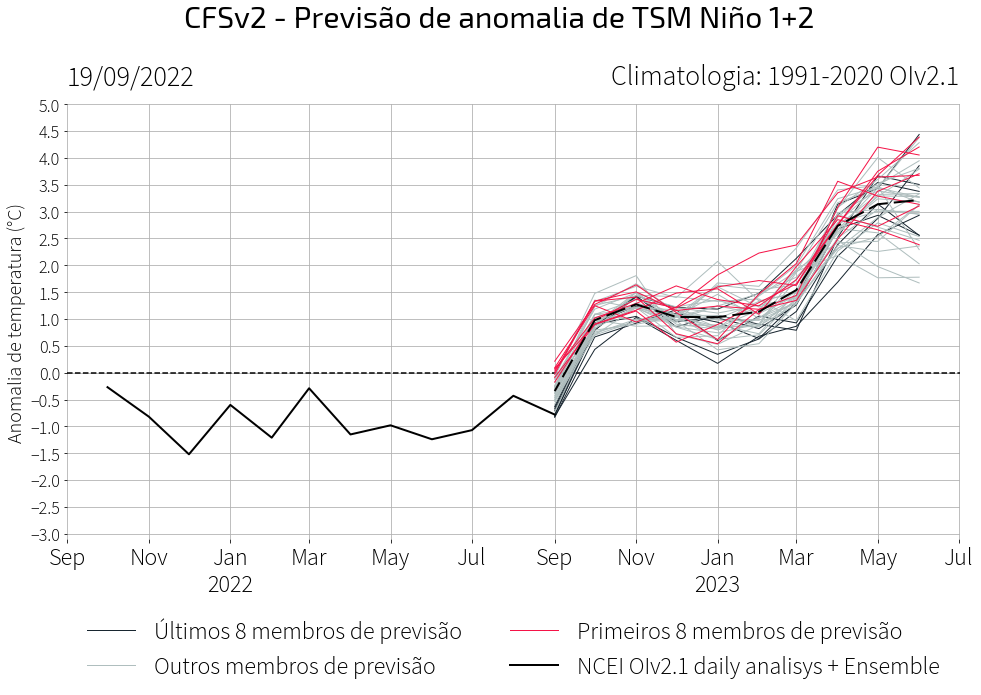

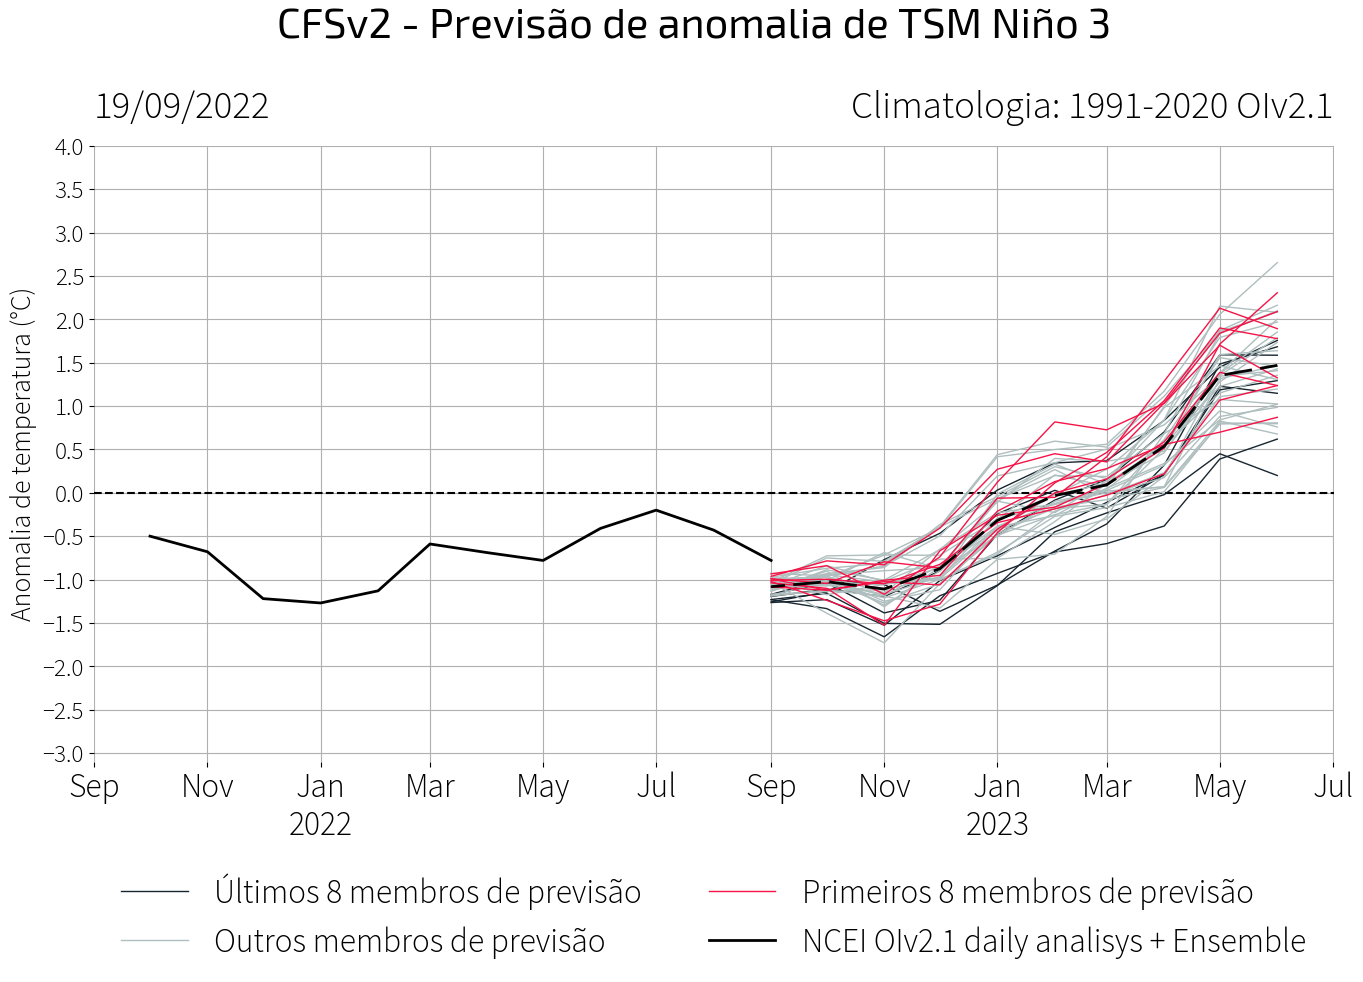

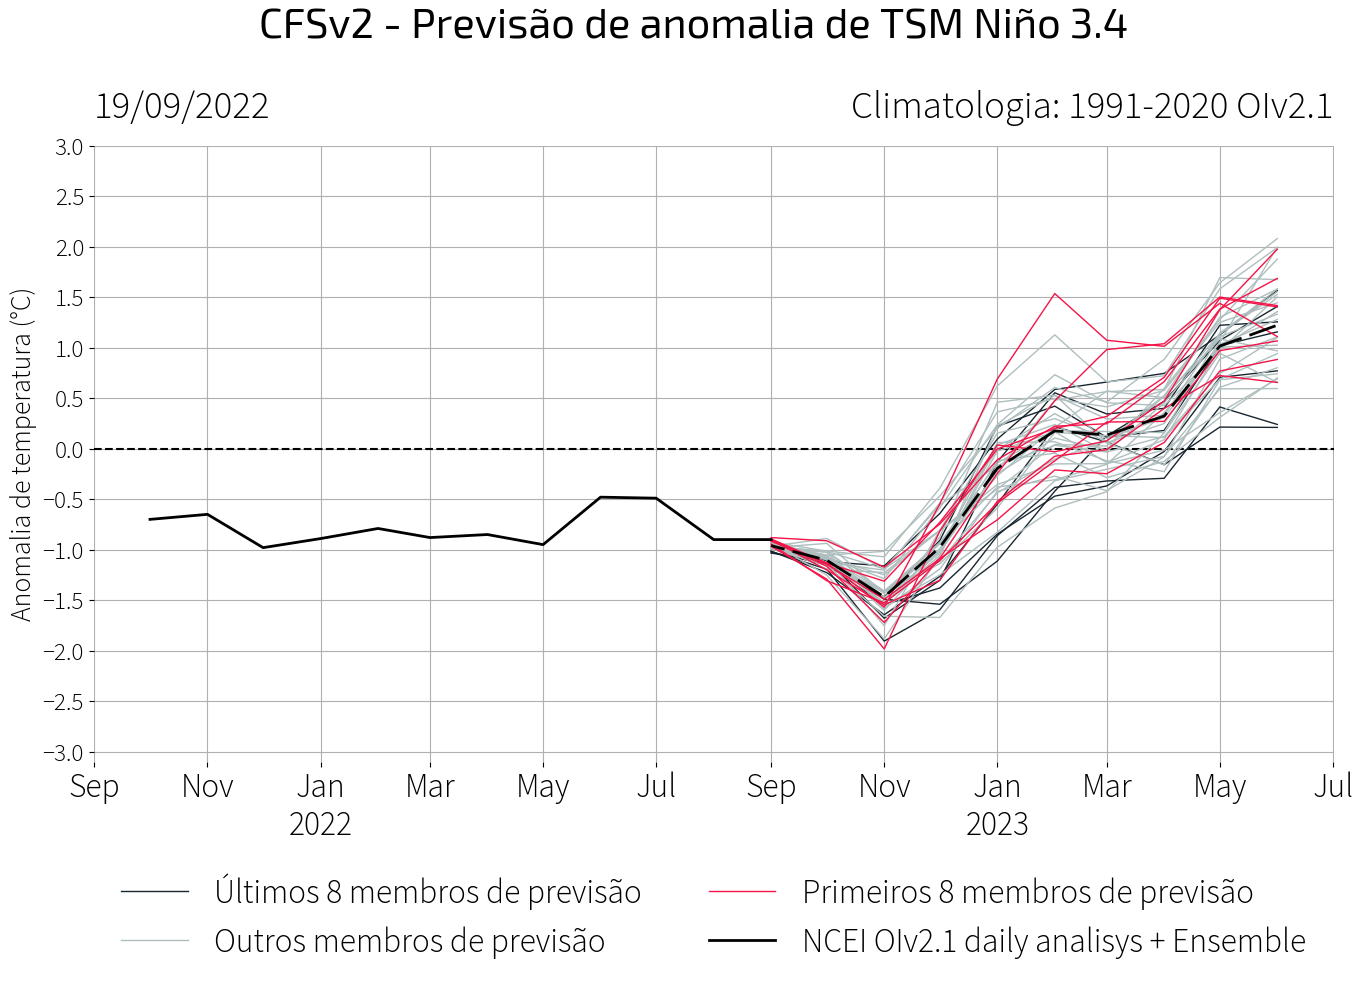

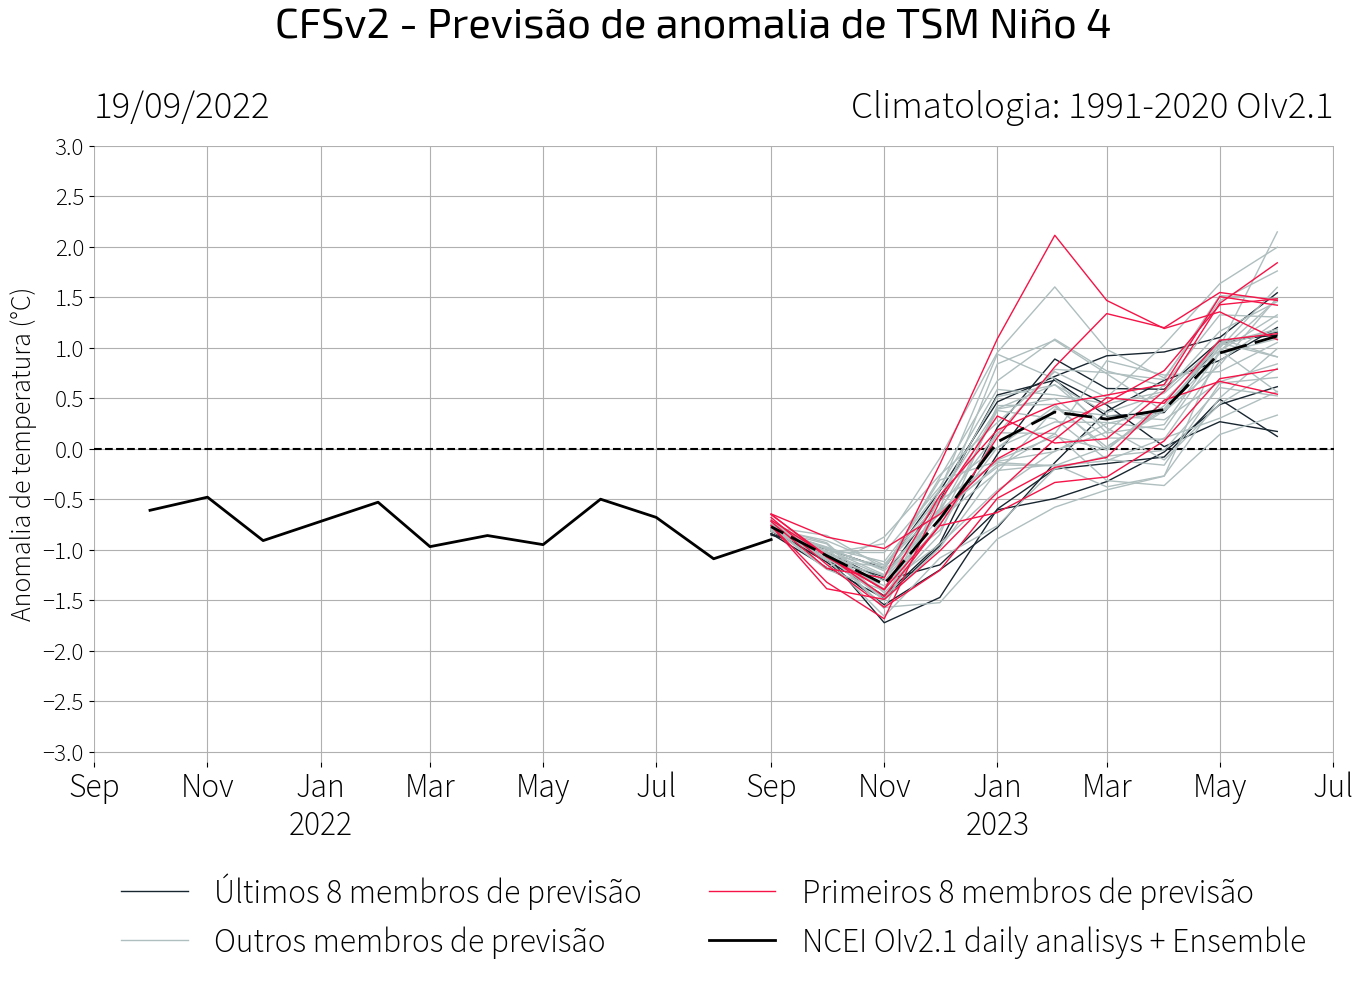

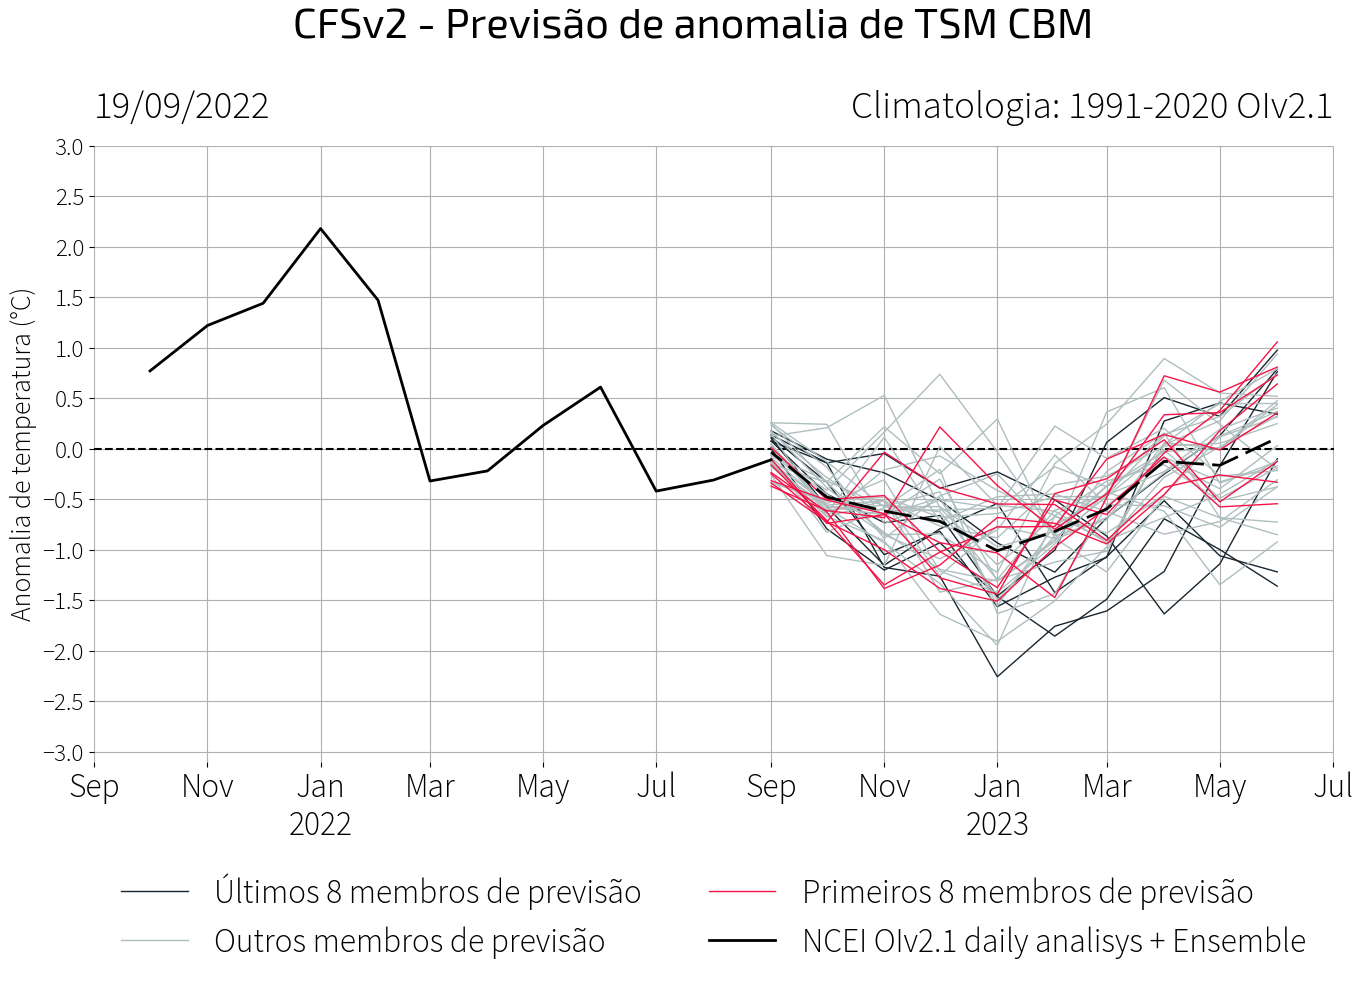

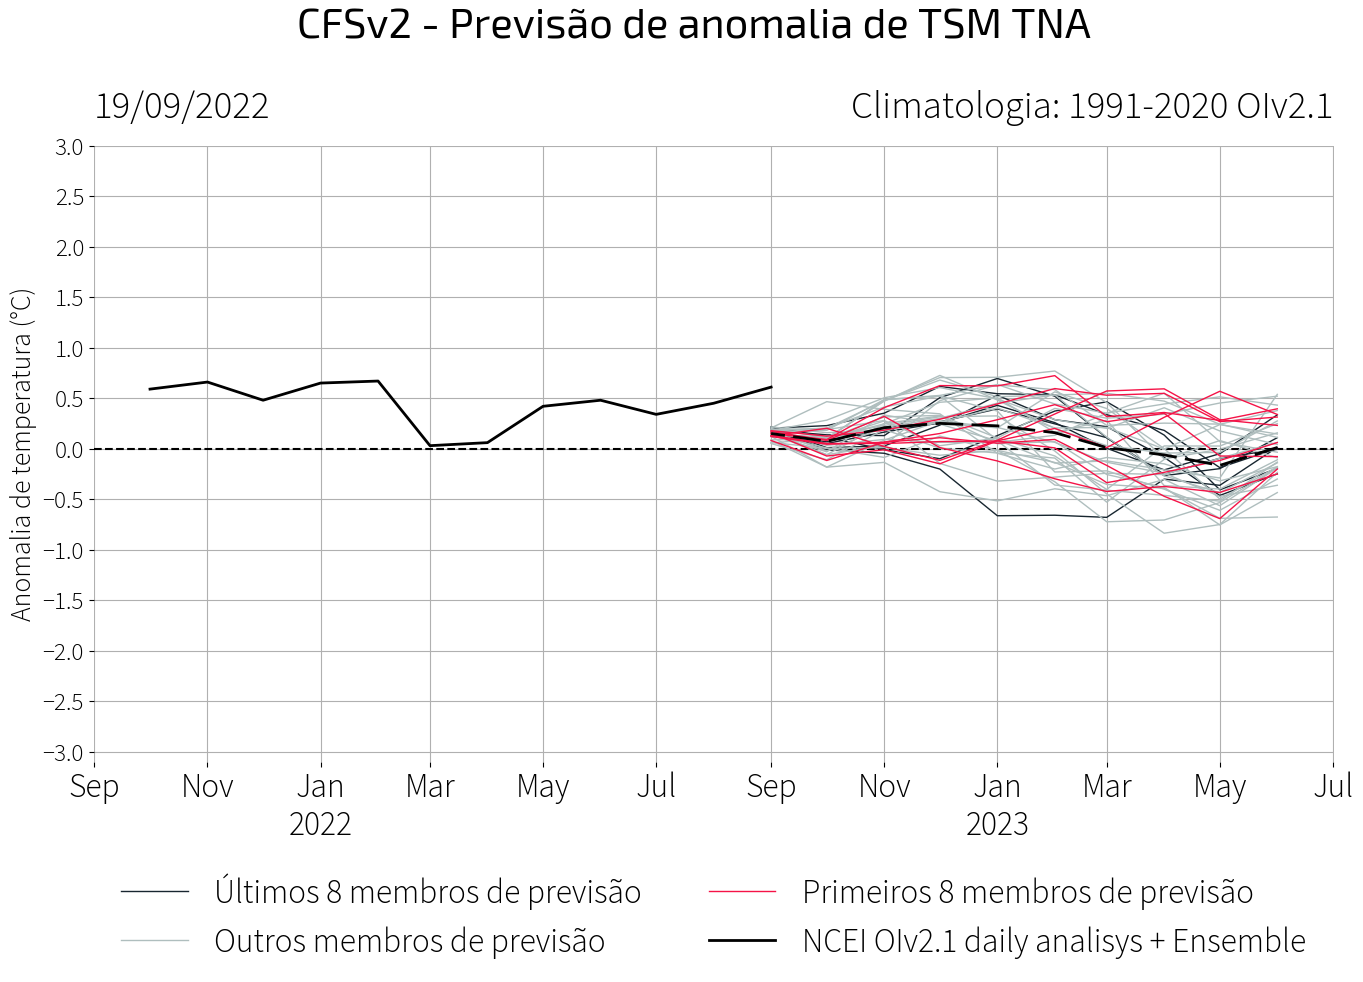

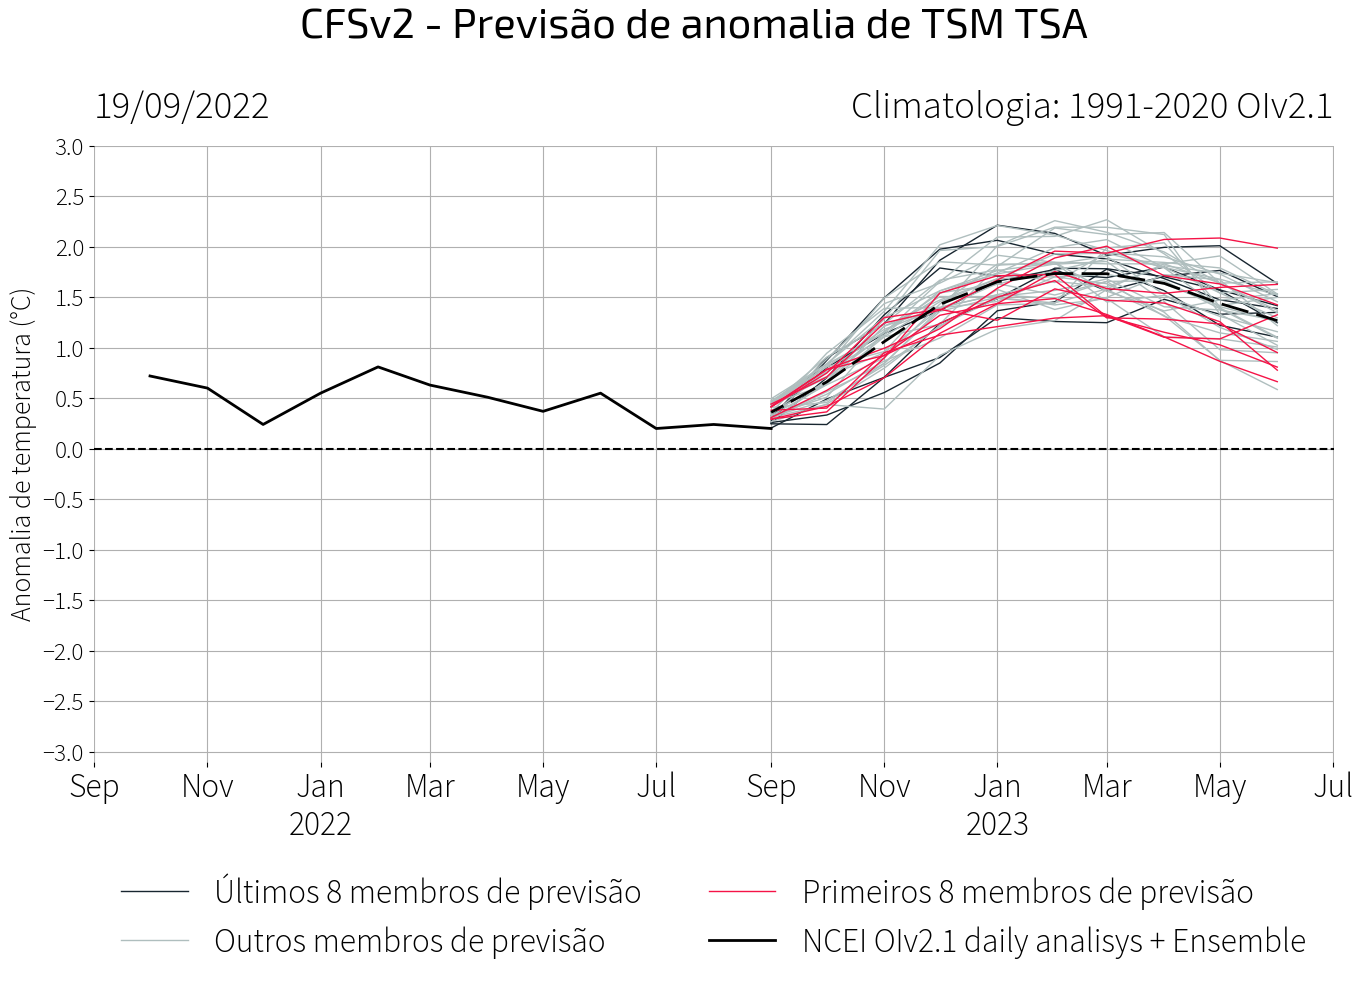

In [32]:
print(f"inicio: {pendulum.now().format('HH:mm:ss')}")

with concurrent.futures.ThreadPoolExecutor(max_workers=45) as executor:
        requisicoes = executor.map(processa_cfs_async, arg1, arg2)
        
dados = list(requisicoes)

for indice in regioes2:
    processo_plot(dados, indice)

print(f"fim: {pendulum.now().format('HH:mm:ss')}")

In [31]:
# fim